# 2. Virtual Watershed PRMS Adapter and Model Service

## Introduction

A major development of the Virtual Watershed project was to develop a variety of adapters for what started as model interoperability, with the thougth that the largest contribution of this project would be to to couple one model to another. We realized that a lot of model coupling work had been done already or would not be feasible in the time allotted for this project, with the exception of [coupling the DFLOW stream flow model with the Riparian Community Alteration and Succession model](https://github.com/VirtualWatershed/CoRD). However we did recognize the importance of creating adapters to make models more accessible by replacing model-specific data formats with the ["Network Common Data Format" or netCDF](http://www.unidata.ucar.edu/software/netcdf/). For more on netCDF itself, please see the previous notebook, [NetCDF with Python](/notebooks/1.%20NetCDF%20with%20Python.ipynb).

## PRMS and the VW PRMS Adapter


Next, we will import the PRMS adapters developed by UNR student Lisa Palathingal. These adapters convert the data and parameter files from PRMS text files to netCDF files which can be plotted, modified, and extended in ways we discussed in the [previous notebook](./notebooks/1.%20NetCDF%20with%20Python.ipynb). 

In [48]:
from prms import data_to_netcdf, parameter_to_netcdf
help(data_to_netcdf)
help(parameter_to_netcdf)

Help on function data_to_netcdf in module prms.prms.text_to_netcdf.dataToNetcdf:

data_to_netcdf(fileInput, outputFileName, event_emitter=None, **kwargs)

Help on function parameter_to_netcdf in module prms.prms.text_to_netcdf.parameterToNetcdf:

parameter_to_netcdf(parameterFile, locationFile, numberOfHruCells, numberOfRows, numberOfColumns, outputFileName, event_emitter=None, **kwargs)



As we can see from the help, `data_to_netcdf` is simple: provide the PRMS text file name, `data_2station` in this case, and provide the name of the output, which is simply the same name with the `.nc` extension appended.

`parameter_to_netcdf` is more complicated and requires extra information. This is because in its base form, PRMS knows nothing about the geometry of the study area. It only knows about the "HRU index", or `nhru`. Parameters are given not in terms of latitude and longitude, or northing and easting, but in terms of `nhru`. While we could mindlessly convert each variable to be a function of `nhru`, we instead use some extra data to make spatially-dependent variables explicitly spatially-dependent. Look for this when we inspect the `jh_coef_hru` variable below.

In [51]:
import os

hru_count = 53361
num_rows = 231
num_cols = 231

data_nc_file = 'data_2station_calib.nc'
param_nc_file = 'params_join_2sta_calib.nc'

# remove existing params and/or data if they exist
try:
    os.remove(data_nc_file)
except:
    pass

try:
    os.remove(pram_nc_file)
except:
    pass

data_to_netcdf('data_2station_calib', data_nc_file)
parameter_to_netcdf('data/params_join_2sta_calib', 'data/XY.DAT.txt', 
                               hru_count, num_rows, num_cols,
                              param_nc_file)


Now that we've created the data and parameter netCDF files, let's inspect, plot, and map some of the data. First we show how `jh_coef_hru` is in fact spatially dependent and plot it wrt to latitude and longitude. 

In [52]:
import netCDF4
param_ds = netCDF4.Dataset('params_join_2sta_calib.nc')
print param_ds

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: 53361 hrus w Incline Active HRUs Model
    version: Version: 1.7
    nsteps: 1
    bands_name: nsteps
    bands_desc: Parameter information for data/params_join_2sta_calib
    number_of_hrus: 53361
    number_of_rows: 231
    number_of_columns: 231
    dimensions(sizes): lat(231), lon(231), ndays(366), nhrucell(53361), one(1), nrain(2), ntemp(2), ncascade(28838), ncascdgw(0), ngw(53361), ngwcell(53361), nhru(53361), nsub(3), ndepl(2), nsegment(51), nreach(861), ndeplval(22), nobs(5), nssr(53361), nmonths(12)
    variables(dimensions): float64 lat(lat), float64 lon(lon), |S1 crs(), int32 hru_tsta(lat,lon), int32 hru_tlaps(lat,lon), int32 hru_segment(lat,lon), float64 gvr_hru_pct(lat,lon), int32 gvr_hru_id(lat,lon), int32 gvr_cell_id(lat,lon), float64 gvr_cell_pct(lat,lon), int32 soil_type(lat,lon), float64 carea_max(lat,lon), int32 transp_beg(lat,lon), float64 hru_lat(lat,lon), float64 hru_ar

To make things easier, we'll create a variable for `param_ds.variables` so we dont' have to keep typing that. We'll just call it `param_vars`. Then we will plot the elevation and two spatially-dependent parameters: the transmission coefficient for short-wave radiation through the winter vegetation canopy (`rad_trncf`) and the summer rain interception coefficients (`srain_intcp`). Both are fractional, meaning they take values from 1 to 0. Plotting gives us a quick visual check that these values are within range and the map of them look reasonable.

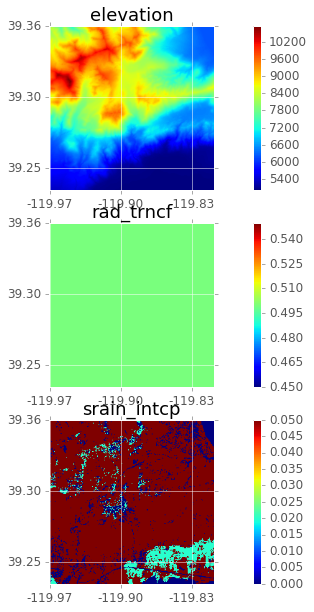

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", module="matplotlib")


param_vars = param_ds.variables
elev = param_vars['hru_elev']
rad_trncf = param_vars['rad_trncf']
srain_intcp = param_vars['srain_intcp']

latvec = param_vars['lat'][:]
lonvec = param_vars['lon'][:]

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 10))

for ax, param, title in zip([ax1, ax2, ax3], [elev, rad_trncf, srain_intcp], ['elevation', 'rad_trncf', 'srain_intcp']):
    p = ax.imshow(param[:])
    ax.set_title(title)
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels(['{0:.2f}'.format(lon) for lon in lonvec[[0, 100, 200]]])
    ax.set_yticks([0, 100, 200])
    ax.set_yticklabels(['{0:.2f}'.format(lat) for lat in latvec[[0, 100, 200]]])
    plt.colorbar(p, ax=ax)

We can also plot what we find in the data file. The PRMS `data` file contains timeseries climate data including temperature and precipitation. We'll use another Python module called `xarray` to load this timeseries data. By following [CF conventions](http://cfconventions.org/) for the time dimension, we have enabled `xarray` to automatically build timeseries of our netCDF variables.

In [54]:
from xarray import open_dataset

data_ds = open_dataset(data_nc_file)
print data_ds

<xarray.Dataset>
Dimensions:   (time: 6583)
Coordinates:
  * time      (time) datetime64[ns] 1990-05-01 1990-05-02 1990-05-03 ...
Data variables:
    tmax_1    (time) float32 35.4 45.3 46.9 52.3 60.8 65.3 58.3 57.4 48.9 ...
    tmax_2    (time) float32 48.0 56.0 59.0 64.0 72.0 76.0 71.0 68.0 60.0 ...
    tmin_1    (time) float32 15.4 20.7 29.7 28.8 36.3 37.2 39.4 35.4 23.5 ...
    tmin_2    (time) float32 30.0 30.0 32.0 37.0 34.0 34.0 30.0 32.0 29.0 ...
    precip_1  (time) float32 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    precip_2  (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.34 0.0 ...
    runoff_1  (time) float32 2.8 2.8 2.7 2.7 2.7 2.7 2.7 2.7 2.6 2.8 2.6 2.5 ...
    runoff_2  (time) float32 4.1 4.1 4.0 4.1 4.0 3.9 3.8 3.7 3.5 3.6 3.5 3.3 ...
    runoff_3  (time) float32 4.9 4.8 4.8 4.7 4.7 4.8 4.6 4.5 4.5 4.8 4.5 4.3 ...
    runoff_4  (time) float32 7.0 7.2 7.5 8.1 8.5 8.8 8.1 6.8 6.4 7.2 6.2 5.7 ...
    runoff_5  (time) float32 9.8 9.7 9.6 9.7 10.0 10.0 10.0

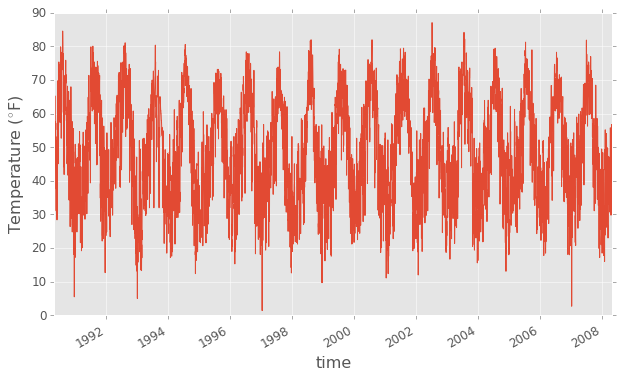

In [56]:
from util.capstone import config_plots
config_plots()
# in a later notebook we will be modifying temperature and precip, so let's look at a couple of those
tmax1 = data_ds.tmax_1

tmax1.plot()
plt.ylabel('Temperature ($^{\circ}$F)')

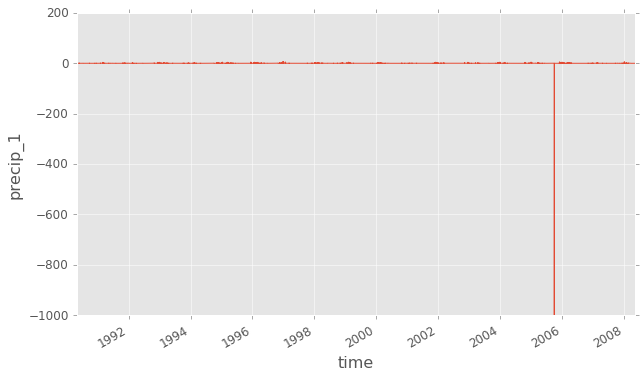

In [57]:
precip_1 = data_ds.precip_1
precip_1.plot()

We have some issues again with nodata values. So let's get rid of those again and see what the precip is like

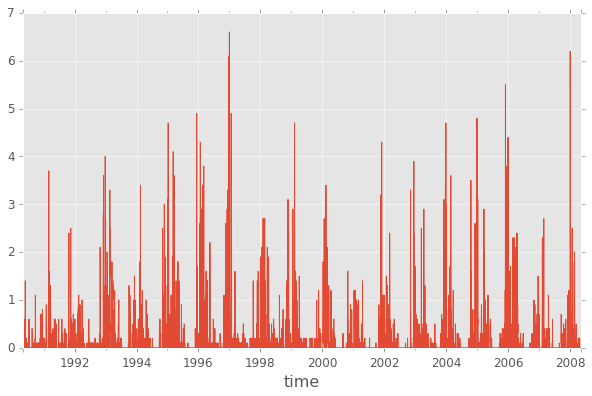

In [58]:
precip_1s = precip_1.to_series()
precip_1s[precip_1s < -100] = np.nan
precip_1s.interpolate(inplace=True)
precip_1s.plot()

Let's zoom in a little bit to see [El Niño of January 1997](https://youtu.be/IvmeUStFvz8). Thanks to the magic of Pandas TimeSeries, we can just put in an ISO 8601-compliant date string and it understands. 

OrderedDict([(u'title', u'Date File'), (u'nsteps', 1), (u'bands_name', u'nsteps'), (u'bands_desc', u'Variable information for Data File')])


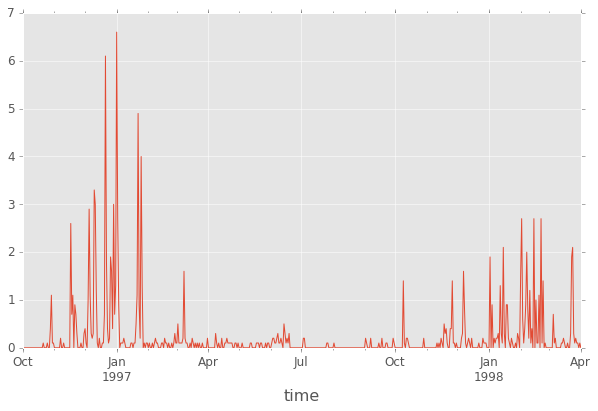

In [59]:
print data_ds.attrs
precip_1s['1996-10-01':'1998-04-01'].plot()

In [30]:
# Import the IPython display module
from IPython.display import IFrame

IFrame('https://www.youtube.com/embed/IvmeUStFvz8', width=500, height=400)


## Run PRMS through the VW Modeling Server with these netCDFs as input

Now that we have some sense of what is included in these PRMS files, let's actually run PRMS. To do this, we'll use a "helper function" that's contained in the `util.capstone` module, or in other words, the file [`util/capstone.py`](./util/capstone.py). This helper function does the leg work of connecting to the server, uploading each file,  submitting the request to the server, and then downloading the model outputs to the appropriate location, creating that location if necessary.

This is the first time we require authentication. Now, make sure you first head to [the VW authentication service](https://auth.virtualwatershed.org) to get sign up and get your authentication token. With that token you can run PRMS or ISNOBAL through the modeling service. ISNOBAL is left as an exercise.

So, click the link above, register, confirm your account through the email it sends, and then click the "API Key" tab. Copy and paste the API key underneath the "except" block below. Or, if you're an advanced user, you could edit `jwt.template.py` and put your token in there.

In [60]:
from util.capstone import run_prms
help(run_prms)

Help on function run_prms in module util.capstone:

run_prms(data, param, control, jwt, output_dir, modelrun_title=None, auth_host='https://auth.virtualwatershed.org/api', model_host='https://model.virtualwatershed.org/api', clobber=True, verify_ssl=False)
    Wrapper for running PRMS using the Virtual Watershed Modeling Service



In [61]:
try:
    from jwt import TOKEN
except:
    TOKEN = 'put your token here!'

output_dir = 'first-prms-run'
control_file = 'gsflow_subs.control'
# control file is necessary part of PRMS, included for convenience in the data/ directory
run_prms(data_nc_file, param_nc_file,
         control_file,  TOKEN, output_dir)

getting state...
state: FINISHED
event: done_prms
run finished, downloading outputs to first-prms-run


### Plot the predicted streamflow

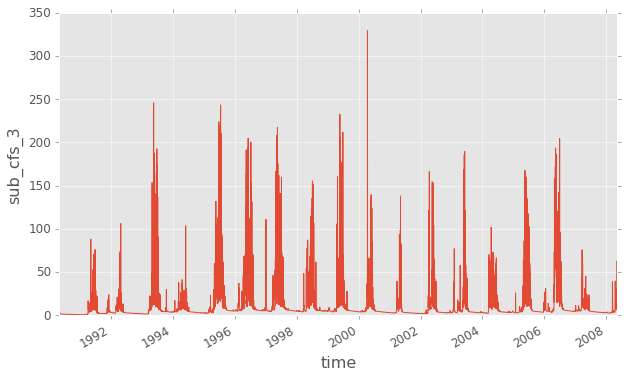

In [63]:
from xarray import open_dataset

ds = open_dataset('first-prms-run/statsvar.nc')

ds.sub_cfs_3.plot()